# Medical Appointment No Shows
## Why do 30% of patients miss their scheduled appointments?

### The Problem
A person makes a doctor appointment, receives all the instructions, and subsequently becomes a no-show.
Since these no-shows bring huge losses to the Brazilian public finances, can I identify which variables are most important to predict  the target variable (show or no-show)?
Can I identify the most important variables in order to show the problems that should be fixed? 
Can I predict which person is most likely to no-show or show  given the features related to that person?
### The Context
The number of no-shows in medical appointments in the health units of the city of Vitória-ES-Brazil reached 30.14% of the total number of appointments made in 2 years (2014/2015);<br>
This pattern is very similar to the brazilian national statistics;<br>
In Vitória alone, this rate represented an approximate loss of 19.5 million reais per year (5.9 million dollars);
Considering all the operational costs of the scheduling, including sending SMS, confirmation links and the professionals involved, this cost reaches almost 2 million reais a month (about 606.000 dollars): a considerable waste!
### Inspiration
Why this data called my attention?<br>
It  was collected in the city where I was born in Brazil (Vitória in Espírito Santo).<br>
It's interesting to work with data that you're familiar with. <br>
This data set was chosen from Kaggle's Dataset platform: https://www.kaggle.com/joniarroba/noshowappointments/data
### Dataset Dictionary
Features (X) - Independent variables:<br>
-PatientId: Identification of a patient - float64<br>
-AppointmentID - Identification of each appointment - int64<br>
-Gender = Male(M) or Female(F)- object<br>
-ScheduledDay = when they have to visit the doctor - object<br>
-AppointmentDay = The day someone called or registered the appointment -object<br>
-Age = The patient's age - int64<br>
-Neighbourhood = The neighboorhood where the appointment will take place - object<br>
-Scholarship = 1 (True), 0 (False) - see explanation bellow - int64<br>
-Hipertension = 1 (True), 0 (False) - int64<br>
-Diabetes = 1 (True), 0 (False) - int64<br>
-Alcoholism = 1 (True), 0 (False) - int64v
-Handcap = 1 (True), 0 (False) - int64<br>
-SMS_received = 1 (True), 0 (False) - int64<br>
Target Variable (y) - Dependent variable:<br>
-No-show = Yes and No - object<br>
### The data's origin
About 1,550,000 (one million, five hundred and fifty thousand) records were collected in two years (2014 and 2015), including a total of 474,833 (four hundred and seventy-four thousand, eight hundred and thirty-three) absences. These absences corresponded to 30.14% of total appointments.

### General Goal:
Build a machine learning model that best generalizes to out-of-sample data;<br>
Know the most important useful variables to predict the target variable;<br>
Predict the classification of the target variable into Show and No-show, given the features in the dataset.
### Specific Goal:
As mentioned in the original dataset, around 30% of patients miss the appointments. 
100% are expected to show.  Consequently all resources are allocated for that.
Using Asymetric Loss Function - a mistake in one direction has a much lower cost than a mistake in the other direction - we can try (in data science basis) to minimize the expectation for patients that will show in the medical appointments and allocate the correct resources (operational costs of the scheduling, including sending SMS, confirmation links and the professionals involved) .
Our goal is to: 
- Maximize True Positive Rate (TPR);
- Minimize False Positive Rate (FPR)
### Cleaning and Processing:
- renamed some columns:  from HiperTension'  to 'hypertension, 'Handcap': to 'handicap', No-show': 'no_show'’
- transformed the columns' names to lowercase;
- encoded the column gender "(M":0 , "F":1) and the column no_show ( "No":0, "Yes":1);
- created a column difday  that  stores  how many days the person has to wait for the appointment day;
- created  a column that is the frequency of past missed appointments;
- dropped  unnecessary columns like 'patientid', 'appointmentid', 'scheduledday', 'appointmentday', 'neighbourhood'.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn import metrics 
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import binarize
from xgboost import XGBClassifier
from datetime import datetime
from datetime import timedelta
from datetime import date
import time
import warnings
from time import time
warnings.filterwarnings('ignore')
%pylab inline
plt.style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


/Users/anapaulavarejao/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/anapaulavarejao/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Cleaning and Processing 

In [2]:
ns = pd.read_csv("KaggleV2-May-2016.csv")
ns.head(2)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No


In [3]:
ns.columns

Index([u'PatientId', u'AppointmentID', u'Gender', u'ScheduledDay',
       u'AppointmentDay', u'Age', u'Neighbourhood', u'Scholarship',
       u'Hipertension', u'Diabetes', u'Alcoholism', u'Handcap',
       u'SMS_received', u'No-show'],
      dtype='object')

In [4]:
ns.rename(columns = { 'HiperTension': 'hypertension',
                      'Handcap': 'handicap',
                      'No-show': 'no_show'}, inplace = True)

In [5]:
ns.columns = [elem.lower() for elem in ns.columns]

In [6]:
#Encoding gender
gender_dict = {"M":0, "F":1}
ns["gender"] = ns.gender.map(gender_dict)

In [7]:
# Encoding no_show
no_show_dict = {"No":0, "Yes":1}
ns["no_show"] = ns.no_show.map(no_show_dict)

In [8]:
ns[["scheduledday","appointmentday"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 2 columns):
scheduledday      110527 non-null object
appointmentday    110527 non-null object
dtypes: object(2)
memory usage: 1.7+ MB


In [9]:
#Extract Day of week, and Hour from datetime(unit Hour only for "ScheduleDay') 

#Convert to datetime
ns["appointmentday"] = pd.to_datetime(ns["appointmentday"])
ns["scheduledday"] = pd.to_datetime(ns["scheduledday"])

ns["dow_sched"]=ns["scheduledday"].dt.dayofweek
ns["dow_app"]=ns["appointmentday"].dt.dayofweek
ns["hour_Sched"]=ns["scheduledday"].dt.hour  # unit Hour only for "ScheduleDay'

In [10]:
#Creating difday
ns["scheduledday"] = ns["scheduledday"].astype(str)
ns["scheduledday"] = ns["scheduledday"].map(lambda x: x[:-8])
ns["scheduledday"] = pd.to_datetime(ns["scheduledday"])
ns["difday"]= ns["appointmentday"] - ns["scheduledday"]
ns["difday"] = ns["difday"].astype(str)
ns["difday"] = ns["difday"].map(lambda x: x[:-23])
ns.drop(ns[ns["difday"] == "-1 d"].index, inplace=True)
ns.drop(ns[ns["difday"] == "-6 d"].index, inplace=True)
ns["difday"] = ns["difday"].astype(int)

In [11]:
#Creating apt_missed
chave = ns.groupby('patientid')['no_show'].apply(lambda x: x.cumsum())
lista = []
for elem in chave:
    if elem == 1:
        lista.append(0)
    else:
        lista.append(elem)
ns["apt_missed"] = lista

In [12]:
#drop rows Age < 0
ns = ns[ns.age>0]

In [13]:
# Drop unecessary columns 
dc = ['patientid', 'appointmentid','scheduledday','appointmentday','neighbourhood']
ns.drop(dc, axis = 1, inplace = True)

In [14]:
#Verifying unique values
keys = ns.columns
commands = ['ns.' + keys[i] + ".unique()" for i in range(len(keys))]
i = 0
for item in commands:
    print "* " + keys[i] + ':'
    print sorted(eval(item))
    i+=1

* gender:
[0, 1]
* age:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 115]
* scholarship:
[0, 1]
* hipertension:
[0, 1]
* diabetes:
[0, 1]
* alcoholism:
[0, 1]
* handicap:
[0, 1, 2, 3, 4]
* sms_received:
[0, 1]
* no_show:
[0, 1]
* dow_sched:
[0, 1, 2, 3, 4, 5]
* dow_app:
[0, 1, 2, 3, 4, 5]
* hour_Sched:
[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
* difday:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 7

In [15]:
ns.columns

Index([u'gender', u'age', u'scholarship', u'hipertension', u'diabetes',
       u'alcoholism', u'handicap', u'sms_received', u'no_show', u'dow_sched',
       u'dow_app', u'hour_Sched', u'difday', u'apt_missed'],
      dtype='object')

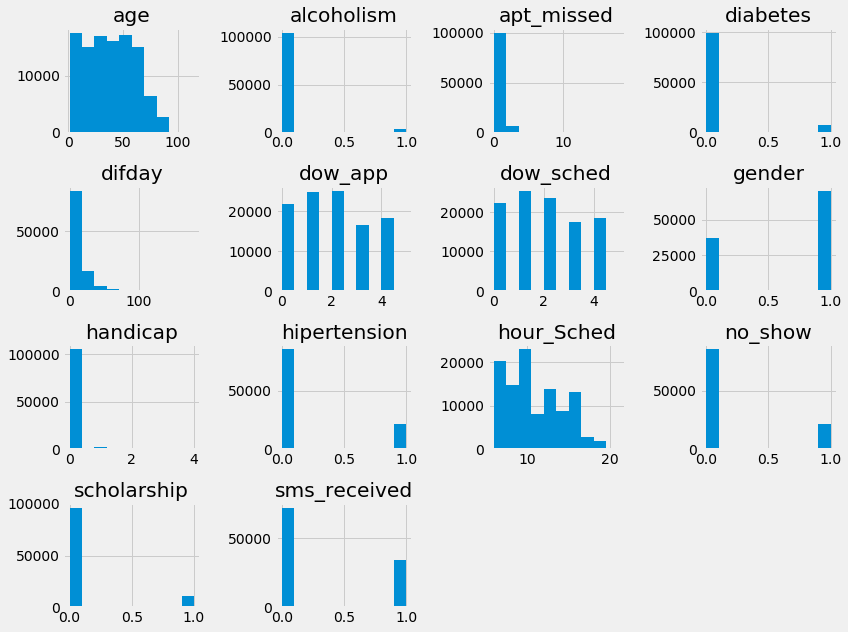

In [16]:
ns.hist(figsize=(12,9))
plt.tight_layout()
plt.show()

In [17]:
ns.columns

Index([u'gender', u'age', u'scholarship', u'hipertension', u'diabetes',
       u'alcoholism', u'handicap', u'sms_received', u'no_show', u'dow_sched',
       u'dow_app', u'hour_Sched', u'difday', u'apt_missed'],
      dtype='object')

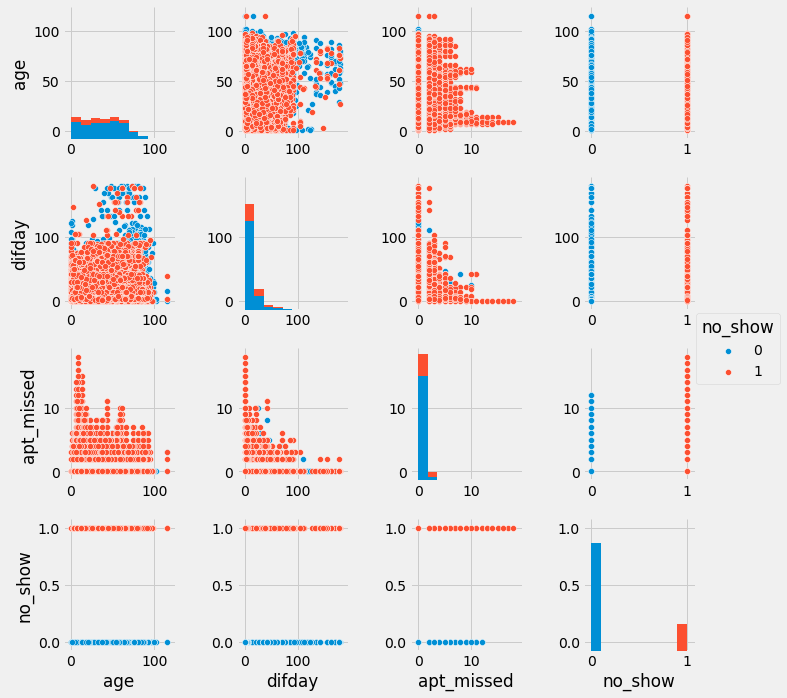

In [18]:
ns_ = ns[['age', 'difday','apt_missed', 'no_show']]
sns.pairplot(ns_, hue="no_show");

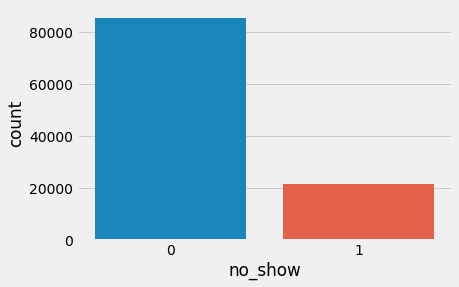

In [19]:
sns.countplot(x="no_show", data=ns)

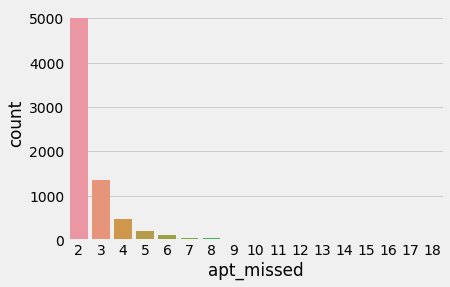

In [20]:
ns_ = ns[ns.apt_missed > 1]
sns.countplot(x ="apt_missed", data= ns_);

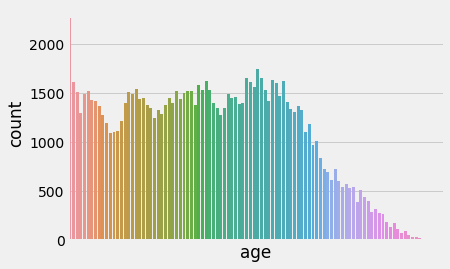

In [21]:
sns.countplot(x="age", data=ns)
plt.tick_params(axis='x',labelbottom='off') # labels along the bottom edge are off              
plt.show()


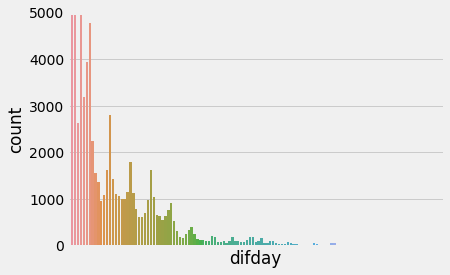

In [22]:
#figure(figsize=(20,15))
sns.countplot(x="difday", data=ns)
plt.ylim(0,5000)
plt.tick_params(axis='x',labelbottom='off') # labels along the bottom edge are off              
plt.show()

In [23]:
ns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106982 entries, 0 to 110526
Data columns (total 14 columns):
gender          106982 non-null int64
age             106982 non-null int64
scholarship     106982 non-null int64
hipertension    106982 non-null int64
diabetes        106982 non-null int64
alcoholism      106982 non-null int64
handicap        106982 non-null int64
sms_received    106982 non-null int64
no_show         106982 non-null int64
dow_sched       106982 non-null int64
dow_app         106982 non-null int64
hour_Sched      106982 non-null int64
difday          106982 non-null int64
apt_missed      106982 non-null int64
dtypes: int64(14)
memory usage: 17.2 MB


In [24]:
ns.no_show.value_counts(normalize=True)

0    0.797396
1    0.202604
Name: no_show, dtype: float64

In [25]:
ns.no_show.value_counts()

0    85307
1    21675
Name: no_show, dtype: int64

In [26]:
X = ns.drop("no_show", axis = 1)
y = ns.no_show

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=0)

## Features Importance : Adaboost

In [28]:
#Features Importance : Adaboost
n_estimators_range = range(50, 300, 50)
param_grid_dt = {}
param_grid_dt["n_estimators"] = n_estimators_range
grid_dt = GridSearchCV(estimator = AdaBoostClassifier(), 
            param_grid = param_grid_dt, cv = 5, scoring = "accuracy")
grid_dt.fit(X, y)
ada = AdaBoostClassifier(n_estimators=grid_dt.best_params_['n_estimators'])
ada.fit(X,y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [29]:
importances = sorted(zip(ada.feature_importances_, X), key = lambda x: x[0], reverse = True)

In [30]:
importances

[(0.32000000000000001, 'age'),
 (0.28000000000000003, 'difday'),
 (0.14000000000000001, 'apt_missed'),
 (0.059999999999999998, 'hour_Sched'),
 (0.040000000000000001, 'sms_received'),
 (0.040000000000000001, 'dow_sched'),
 (0.040000000000000001, 'dow_app'),
 (0.02, 'gender'),
 (0.02, 'scholarship'),
 (0.02, 'diabetes'),
 (0.02, 'alcoholism'),
 (0.0, 'hipertension'),
 (0.0, 'handicap')]

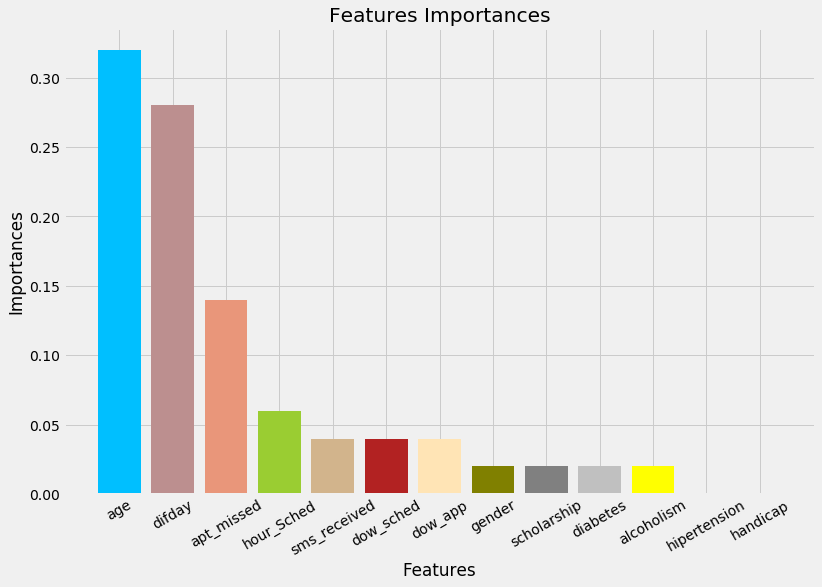

In [31]:
label = []
val = []
for i, elem in importances:
    label.append(elem)
    val.append(i)
        
label_ = label
pos = range(1,len(importances)+1)
colors = ['deepskyblue', 'rosybrown', 'darksalmon', 'yellowgreen', 'tan', 'firebrick', 'moccasin', 'olive', 
          'grey', 'silver', 'yellow', 'green', 'red']
          
w = 0.8

#Matplotlib
plt.figure(figsize = (12,8))
plt.bar(pos, width=w, height=val, color = colors, tick_label = label_,  align="center")
plt.ylabel("Importances")
plt.xticks(rotation=30)
plt.xlabel("Features")
plt.title("Features Importances")
plt.show()


## More Action Selecting Features

In [32]:
lista = [elem[1] for elem in importances]

In [33]:
# 1 Feature
lista_1f = lista[0:1]
X = ns[lista_1f]

In [34]:
n_estimators_range = range(50, 300, 50)
param_grid_dt = {}
param_grid_dt["n_estimators"] = n_estimators_range
grid_dt = GridSearchCV(estimator = AdaBoostClassifier(), 
            param_grid = param_grid_dt, cv = 5, scoring = "accuracy")
grid_dt.fit(X, y)
ada = AdaBoostClassifier(n_estimators=grid_dt.best_params_['n_estimators'])
ada.fit(X,y)
cv_ada = cross_val_score(ada, X, y, cv=5, scoring="accuracy").mean()
print round(cv_ada,4)

0.7974


In [35]:
# 2 Features
lista_2f = lista[0:2]
X = ns[lista_2f]

In [36]:
n_estimators_range = range(50, 300, 50)
param_grid_dt = {}
param_grid_dt["n_estimators"] = n_estimators_range
grid_dt = GridSearchCV(estimator = AdaBoostClassifier(), 
            param_grid = param_grid_dt, cv = 5, scoring = "accuracy")
grid_dt.fit(X, y)
ada = AdaBoostClassifier(n_estimators=grid_dt.best_params_['n_estimators'])
ada.fit(X,y)
cv_ada = cross_val_score(ada, X, y, cv=5, scoring="accuracy").mean()
print round(cv_ada,4)

0.7973


In [37]:
# 3 Features
lista_3f = lista[0:3]
X = ns[lista_3f]

In [38]:
n_estimators_range = range(50, 300, 50)
param_grid_dt = {}
param_grid_dt["n_estimators"] = n_estimators_range
grid_dt = GridSearchCV(estimator = AdaBoostClassifier(), 
            param_grid = param_grid_dt, cv = 5, scoring = "accuracy")
grid_dt.fit(X, y)
ada = AdaBoostClassifier(n_estimators=grid_dt.best_params_['n_estimators'])
ada.fit(X,y)
cv_ada = cross_val_score(ada, X, y, cv=5, scoring="accuracy").mean()
print round(cv_ada,4)

0.8207


In [39]:
# 4 Features
lista_4f = lista[0:4]
X = ns[lista_4f]

In [40]:
n_estimators_range = range(50, 300, 50)
param_grid_dt = {}
param_grid_dt["n_estimators"] = n_estimators_range
grid_dt = GridSearchCV(estimator = AdaBoostClassifier(), 
            param_grid = param_grid_dt, cv = 5, scoring = "accuracy")
grid_dt.fit(X, y)
ada = AdaBoostClassifier(n_estimators=grid_dt.best_params_['n_estimators'])
ada.fit(X,y)
cv_ada = cross_val_score(ada, X, y, cv=5, scoring="accuracy").mean()
print round(cv_ada,4)

0.8206


In [41]:
# 5 Features
lista_5f = lista[0:5]
X = ns[lista_5f]

In [42]:
n_estimators_range = range(50, 300, 50)
param_grid_dt = {}
param_grid_dt["n_estimators"] = n_estimators_range
grid_dt = GridSearchCV(estimator = AdaBoostClassifier(), 
            param_grid = param_grid_dt, cv = 5, scoring = "accuracy")
grid_dt.fit(X, y)
ada = AdaBoostClassifier(n_estimators=grid_dt.best_params_['n_estimators'])
ada.fit(X,y)
cv_ada = cross_val_score(ada, X, y, cv=5, scoring="accuracy").mean()
print round(cv_ada,4)

0.8206


In [43]:
# 6 Features
lista_6f = lista[0:6]
X = ns[lista_6f]

In [44]:
n_estimators_range = range(50, 300, 50)
param_grid_dt = {}
param_grid_dt["n_estimators"] = n_estimators_range
grid_dt = GridSearchCV(estimator = AdaBoostClassifier(), 
            param_grid = param_grid_dt, cv = 5, scoring = "accuracy")
grid_dt.fit(X, y)
ada = AdaBoostClassifier(n_estimators=grid_dt.best_params_['n_estimators'])
ada.fit(X,y)
cv_ada = cross_val_score(ada, X, y, cv=5, scoring="accuracy").mean()
print round(cv_ada,4)

0.8206


In [45]:
#7 Features
lista_7f = lista[0:7]
X = ns[lista_7f]

In [46]:
n_estimators_range = range(50, 300, 50)
param_grid_dt = {}
param_grid_dt["n_estimators"] = n_estimators_range
grid_dt = GridSearchCV(estimator = AdaBoostClassifier(), 
            param_grid = param_grid_dt, cv = 5, scoring = "accuracy")
grid_dt.fit(X, y)
ada = AdaBoostClassifier(n_estimators=grid_dt.best_params_['n_estimators'])
ada.fit(X,y)
cv_ada = cross_val_score(ada, X, y, cv=5, scoring="accuracy").mean()
print round(cv_ada,4)

0.8205


In [47]:
#8 Features
lista_8f = lista[0:8]
X = ns[lista_8f]

In [48]:
n_estimators_range = range(50, 300, 50)
param_grid_dt = {}
param_grid_dt["n_estimators"] = n_estimators_range
grid_dt = GridSearchCV(estimator = AdaBoostClassifier(), 
            param_grid = param_grid_dt, cv = 5, scoring = "accuracy")
grid_dt.fit(X, y)
ada = AdaBoostClassifier(n_estimators=grid_dt.best_params_['n_estimators'])
ada.fit(X,y)
cv_ada = cross_val_score(ada, X, y, cv=5, scoring="accuracy").mean()
print round(cv_ada,4)

0.8205


In [49]:
#9 Features
lista_9f = lista[0:9]
X = ns[lista_9f]

In [50]:
n_estimators_range = range(50, 300, 50)
param_grid_dt = {}
param_grid_dt["n_estimators"] = n_estimators_range
grid_dt = GridSearchCV(estimator = AdaBoostClassifier(), 
            param_grid = param_grid_dt, cv = 5, scoring = "accuracy")
grid_dt.fit(X, y)
ada = AdaBoostClassifier(n_estimators=grid_dt.best_params_['n_estimators'])
ada.fit(X,y)
cv_ada = cross_val_score(ada, X, y, cv=5, scoring="accuracy").mean()
print round(cv_ada,4)

0.8206


### Final Selection: 3 features - age, difday and apt_missed: including new features (more than 3) the accuracy score did not get higher.

In [51]:
# Let's drop the features bellow:

dr = ['hour_Sched',
 'sms_received',
 'dow_sched',
 'dow_app',
 'gender',
 'scholarship',
 'diabetes',
 'alcoholism',
 'hipertension',
 'handicap']
ns.drop(dr, axis = 1, inplace = True)

In [52]:
#Assign features to variable X
X = ns.drop("no_show", axis = 1)
#Assign target column to variable y
y = ns.no_show

In [53]:
y.value_counts(normalize=True)

0    0.797396
1    0.202604
Name: no_show, dtype: float64

## Prediction

### Question: Can we predict if a patients will no-show given some features related to them?

#### Let's Start it !!!!

In [54]:
#Split the data set into 70% training and 30% testing (where I going to see the performance):
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,random_state=0)

## 1) AdaBoost

In [55]:
n_estimators_range = range(50, 300, 50)
param_grid_dt = {}
param_grid_dt["n_estimators"] = n_estimators_range
grid_dt = GridSearchCV(estimator = AdaBoostClassifier(), 
            param_grid = param_grid_dt, cv = 5, scoring = "accuracy")
grid_dt.fit(X_train, y_train)
ada = AdaBoostClassifier(n_estimators=grid_dt.best_params_['n_estimators'])
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)
scores = cross_val_score(ada, X_test, y_test, cv=5)
print "Accuracy: %0.4f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2)
print classification_report(y_test, y_pred)
print confusion_matrix(y_test, y_pred)


Accuracy: 0.8211 (+/- 0.01)

             precision    recall  f1-score   support

          0       0.83      0.98      0.90     25619
          1       0.71      0.19      0.30      6476

avg / total       0.80      0.82      0.78     32095

[[25119   500]
 [ 5237  1239]]


In [56]:
cm = confusion_matrix(y_test, y_pred)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
tot_a_1 = TN + FP
tot_a_2 = FN + TP
tot_p_1 = TN + FN
tot_p_2 = FP + TP
tot_g = tot_a_1+tot_a_2
mx =np.array(["TN",TN,"FP",FP,tot_a_1,"FN",FN,"TP", TP, tot_a_2,"", tot_p_1,"", tot_p_2, tot_g]).reshape(3,5)
cols = [" ","pred0", " ", "pred1",  "total"]
index = ["corr0", "corr1", "total"]
cm_df = pd.DataFrame(mx, columns=cols, index=index )
print cm_df
print "\t"
tpr = round(TP / float(TP + FN),4)
tnr = round(TN / float(TN + FP),4)
fpr = round(FP / float(TN + FP),4)
fnr = round(FN / float(FN + TP),4)
print "Sensitivity or Recall or TPR:", tpr*100, "%"
print "Specificity or TNR:", tnr*100,"%"
print "FPR:", fpr*100,"%"
print "FNR:", fnr*100,"%"

           pred0     pred1  total
corr0  TN  25119  FP   500  25619
corr1  FN   5237  TP  1239   6476
total      30356      1739  32095
	
Sensitivity or Recall or TPR: 19.13 %
Specificity or TNR: 98.05 %
FPR: 1.95 %
FNR: 80.87 %


## 2) XGBClassifier

In [57]:
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.4f%%" % (accuracy * 100.0))
print classification_report(y_test, y_pred)
print confusion_matrix(y_test, y_pred)

Accuracy: 82.1717%
             precision    recall  f1-score   support

          0       0.83      0.98      0.90     25619
          1       0.70      0.20      0.31      6476

avg / total       0.80      0.82      0.78     32095

[[25059   560]
 [ 5162  1314]]


In [58]:
cm = confusion_matrix(y_test, y_pred)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
tot_a_1 = TN + FP
tot_a_2 = FN + TP
tot_p_1 = TN + FN
tot_p_2 = FP + TP
tot_g = tot_a_1+tot_a_2
mx =np.array(["TN",TN,"FP",FP,tot_a_1,"FN",FN,"TP", TP, tot_a_2,"", tot_p_1,"", tot_p_2, tot_g]).reshape(3,5)
cols = [" ","pred0", " ", "pred1",  "total"]
index = ["corr0", "corr1", "total"]
cm_df = pd.DataFrame(mx, columns=cols, index=index )
print cm_df
print "\t"
tpr = round(TP / float(TP + FN),4)
tnr = round(TN / float(TN + FP),4)
fpr = round(FP / float(TN + FP),4)
fnr = round(FN / float(FN + TP),4)
print "Sensitivity or Recall or TPR:", tpr*100, "%"
print "Specificity or TNR:", tnr*100,"%"
print "FPR:", fpr*100,"%"
print "FNR:", fnr*100,"%"

           pred0     pred1  total
corr0  TN  25059  FP   560  25619
corr1  FN   5162  TP  1314   6476
total      30221      1874  32095
	
Sensitivity or Recall or TPR: 20.29 %
Specificity or TNR: 97.81 %
FPR: 2.19 %
FNR: 79.71 %


## 3) Random Forest

In [59]:
#Random Forest
n_estimators_range = range(1, 50)
param_grid_dt = {}
param_grid_dt["n_estimators"] = n_estimators_range
grid_dt = GridSearchCV(estimator = RandomForestClassifier(), 
                        param_grid = param_grid_dt, cv = 5, scoring = "accuracy")
grid_dt.fit(X_train, y_train)
rf = RandomForestClassifier(n_estimators=grid_dt.best_params_['n_estimators'])
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)                
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.4f%%" % (accuracy * 100.0))
print classification_report(y_test, y_pred)
print confusion_matrix(y_test, y_pred)


Accuracy: 80.2991%
             precision    recall  f1-score   support

          0       0.83      0.95      0.88     25619
          1       0.53      0.23      0.32      6476

avg / total       0.77      0.80      0.77     32095

[[24260  1359]
 [ 4964  1512]]


In [60]:
cm = confusion_matrix(y_test, y_pred)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
tot_a_1 = TN + FP
tot_a_2 = FN + TP
tot_p_1 = TN + FN
tot_p_2 = FP + TP
tot_g = tot_a_1+tot_a_2
mx =np.array(["TN",TN,"FP",FP,tot_a_1,"FN",FN,"TP", TP, tot_a_2,"", tot_p_1,"", tot_p_2, tot_g]).reshape(3,5)
cols = [" ","pred0", " ", "pred1",  "total"]
index = ["corr0", "corr1", "total"]
cm_df = pd.DataFrame(mx, columns=cols, index=index )
print cm_df
print "\t"
tpr = round(TP / float(TP + FN),4)
tnr = round(TN / float(TN + FP),4)
fpr = round(FP / float(TN + FP),4)
fnr = round(FN / float(FN + TP),4)
print "Sensitivity or Recall or TPR:", tpr*100, "%"
print "Specificity or TNR:", tnr*100,"%"
print "FPR:", fpr*100,"%"
print "FNR:", fnr*100,"%"

           pred0     pred1  total
corr0  TN  24260  FP  1359  25619
corr1  FN   4964  TP  1512   6476
total      29224      2871  32095
	
Sensitivity or Recall or TPR: 23.35 %
Specificity or TNR: 94.7 %
FPR: 5.3 %
FNR: 76.65 %


## 4) Logistic Regression

In [61]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)                
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.4f%%" % (accuracy * 100.0))
print classification_report(y_test, y_pred)
print confusion_matrix(y_test, y_pred)


Accuracy: 81.1248%
             precision    recall  f1-score   support

          0       0.82      0.98      0.89     25619
          1       0.63      0.16      0.25      6476

avg / total       0.78      0.81      0.76     32095

[[25027   592]
 [ 5466  1010]]


In [64]:
cm = confusion_matrix(y_test, y_pred)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
tot_a_1 = TN + FP
tot_a_2 = FN + TP
tot_p_1 = TN + FN
tot_p_2 = FP + TP
tot_g = tot_a_1+tot_a_2
mx =np.array(["TN",TN,"FP",FP,tot_a_1,"FN",FN,"TP", TP, tot_a_2,"", tot_p_1,"", tot_p_2, tot_g]).reshape(3,5)
cols = [" ","pred0", " ", "pred1",  "total"]
index = ["corr0", "corr1", "total"]
cm_df = pd.DataFrame(mx, columns=cols, index=index )
print cm_df
print "\t"
tpr = round(TP / float(TP + FN),4)
tnr = round(TN / float(TN + FP),4)
fpr = round(FP / float(TN + FP),4)
fnr = round(FN / float(FN + TP),4)
print "Sensitivity or Recall or TPR:", tpr*100, "%"
print "Specificity or TNR:", tnr*100,"%"
print "FPR:", fpr*100,"%"
print "FNR:", fnr*100,"%"

            pred0     pred1  total
corr0  TN  25027  FP   592  25619
corr1  FN   5466  TP  1010   6476
total      30493      1602  32095
	
Sensitivity or Recall or TPR: 15.6 %
Specificity or TNR: 97.69 %
FPR: 2.31 %
FNR: 84.4 %


## Conclusion